# pysat demo using pysatSeasons for generalized instrument independent analysis

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pds
import warnings

In [3]:
import pysat
import pysatSeasons

In [4]:
# Set data directory if user hasn't already set one
print(f"old: {pysat.params['data_dirs']}")
if len(pysat.params['data_dirs']) == 0 or pysat.params['data_dirs'] == ['.']:
    # Set a directory for pysat to use for data
    pysat.params['data_dirs'] = '/home/jovyan/scratch_space/.pysat/'
else:
    print('pysat directory has been set previously. Leaving unchanged.')

print(f"new: {pysat.params['data_dirs']}")

old: ['/home/jovyan/scratch_space/.pysat']
pysat directory has been set previously. Leaving unchanged.
new: ['/home/jovyan/scratch_space/.pysat']


In [5]:
# Register pysatNASA ICON IVM data plug-in. Only required once per install.
import pysatNASA
pysat.utils.registry.register(['pysatNASA.instruments.icon_ivm'])

In [6]:
# Orbit breakdown info
orbit_info = {'kind': 'lt', 'index':'Magnetic_Local_Time'}

# We will employ a centered time-based calculation. Engage pysat's data padding.
pad = pds.DateOffset(seconds=30)

# Instantiate IVM instrument data and 
ivm = pysat.Instrument('icon', 'ivm', inst_id='a', orbit_info=orbit_info,
                       pad=pad)

# Set the range of dates for the analysis
ivm.bounds = (dt.datetime(2020, 1, 1), dt.datetime(2020, 1, 5))

# Improvements for loading ICON metadata are currently in 
# https://github.com/pysat/pysatNASA/pull/100. 
warnings.simplefilter('ignore', UserWarning)


In [7]:
# Modify data as it is loaded to add a log ion density measurement
def add_std_dens(inst):
    """Calculate Standard Deviation in Ion Density.
    
    Parameters
    ----------
    inst : pysat.Instrument
        Instrument object to operate upon.
        
    """
    inst['Ion_Density_STD'] = inst['Ion_Density'].rolling('30s', center=True).std()
    
    return

# Attach to IVM
ivm.custom_attach(add_std_dens)


In [8]:
# Load some data to get a sense of values
ivm.load(2020, 1)

<AxesSubplot:xlabel='Epoch'>

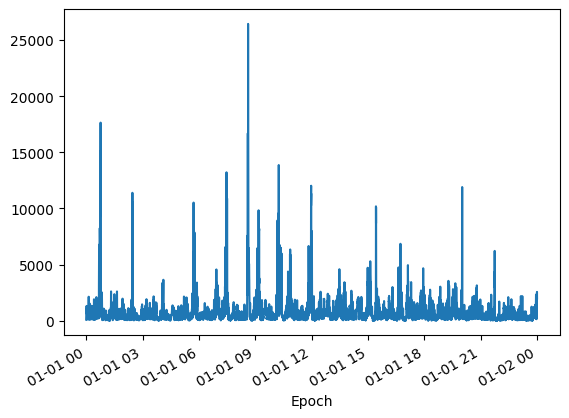

In [9]:
# Plot standard deviation
ivm['Ion_Density_STD'].plot()

In [10]:
# Run Occurrence Probability
answer = pysatSeasons.occur_prob.by_orbit2D(ivm, [0, 360, 24], 'Longitude',
                                            [-20, 20, 10], 'Magnetic_Latitude',
                                            ['Ion_Density_STD'], [5.E3], returnBins=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pysatSeasons/occur_prob.py:260: RuntimeWarning: invalid value encountered in divide
  prob = hits / total


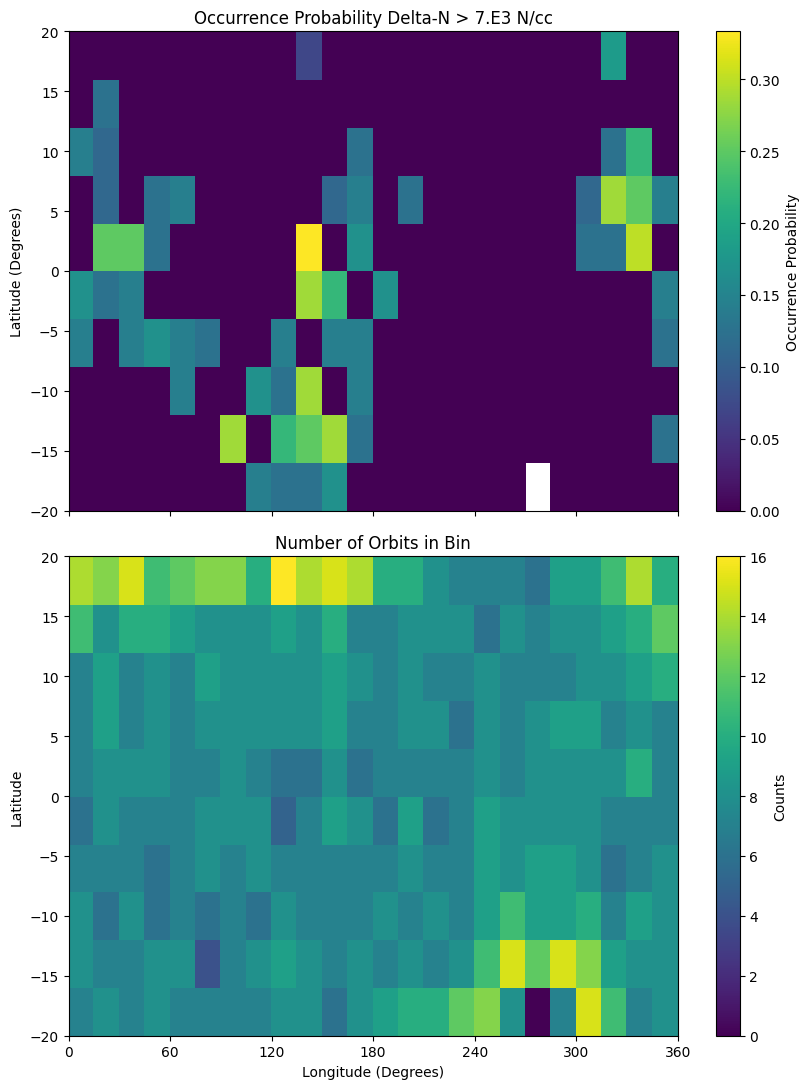

In [11]:
# A dict indexed by data_label is returned.
ans = answer['Ion_Density_STD']

# Plot occurrence probability
f, axarr = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8.5, 11))

# Mask for locations not observed.
masked = np.ma.array(ans['prob'], mask=np.isnan(ans['prob']))

# Plot occurrence probability
im = axarr[0].pcolor(ans['bin_x'], ans['bin_y'], masked)
axarr[0].set_title('Occurrence Probability Delta-N > 7.E3 N/cc')
axarr[0].set_ylabel('Latitude (Degrees)')
axarr[0].set_yticks((-20, -15, -10, -5, 0, 5, 10, 15, 20))
axarr[0].set_ylim((ans['bin_y'][0], ans['bin_y'][-1]))
plt.colorbar(im, ax=axarr[0], label='Occurrence Probability')

# Plot number of orbits per bin.
im = axarr[1].pcolor(ans['bin_x'], ans['bin_y'], ans['count'])
axarr[1].set_title('Number of Orbits in Bin')
axarr[1].set_xlabel('Longitude (Degrees)')
axarr[1].set_xticks((0, 60, 120, 180, 240, 300, 360))
axarr[1].set_xlim((ans['bin_x'][0], ans['bin_x'][-1]))
axarr[1].set_ylabel('Latitude')
plt.colorbar(im, ax=axarr[1], label='Counts')

f.tight_layout()